In [1]:
from multi_nutrient_model import insulin_clamp_dynamic, ref_parameters, TAU_INS, equation, fluxes, REF_STEADY_STATE_VALUES, I0
import numpy as np

In [2]:
# Test model 
x0=[1.0,1.0,1.0,1.0,I0,I0]
equation(x0,1,ref_parameters())

# Check if fluxes are correct
fluxes(x0,1,ref_parameters())[:10] - REF_STEADY_STATE_VALUES[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [3]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']


# Palatte for insulin resitance panels (Baseline, Insulin, Inuslin + Perturbation)
palette = ['#8E8E8E' ,'#C959C5', '#4FC452', ]


In [4]:
time = np.linspace(0,120,100)

vI_low = I0/TAU_INS # Double basal fasted insulin levles
vI_high = I0/TAU_INS * 3 # Two time low dose

In [ ]:
# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 

# GIR scaling 
sGIR = vE * 180 * 1e-3

# Infusion rates for the perurbative infusions 

# 3HB # Scale based on how much of the Fcirc is acounted for 
# By 3HB at rest
sK =  14/27
R_3HB = 120/vE * sK

# Lactate # Scale based on how much of the Fcirc is acounted for 
# By lactate at rest
sL = 200/150
R_lactate = 130.5/vE * sL

In [6]:
# Load all the experimental data

# Glucose infusion rate
GIR_clamp_intralipid = pd.read_csv('data/Intralipid_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

GIR_clamp_3HB = pd.read_csv('data/3HB_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

GIR_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

# Fatty acids 
FFA_clamp_intralipid = pd.read_csv('data/Intralipid_clamp_insulin_dose_FFA.csv', index_col=0)\
                        .melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'Species', 'value':'FFA'})

FFA_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_FFA.csv', index_col=0)\
                        .melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'Species', 'value':'FFA'})

# 3HB and lactate
_3HB_clamp_3HB = pd.read_csv('data/3HB_clamp_insulin_dose_3HB.csv', index_col=0).melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'time', 'value':'3HB'})
lactate_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_lactate.csv', index_col=0).melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'time', 'value':'lactate'})

# Clean up variable names
dataframes = [GIR_clamp_intralipid, GIR_clamp_3HB, GIR_clamp_lactate, FFA_clamp_intralipid, FFA_clamp_lactate, _3HB_clamp_3HB, lactate_clamp_lactate]

for df in dataframes:
    # Remove trailing ".number" from variable names
    df.loc[:,'variable'] = df.loc[:,'variable'].str.replace(r'\.\d+$','')


In [7]:
K_i_ketogenesis = 0.2
R_fatty_acids = 0.008
p_fited = ref_parameters( K_i_ketogenesis = K_i_ketogenesis)

In [8]:
x_insulin_low, GIR_insulin_low = insulin_clamp_dynamic(vI_low, time, 1, p=p_fited)
x_insulin_high, GIR_insulin_high = insulin_clamp_dynamic(vI_high, time, 1, p=p_fited)

In [9]:
from multi_nutrient_model import steady_state, fluxes
fluxes([1.0,1.0,1.0,1.0,I0,I0],1,p_fited)[:10] - REF_STEADY_STATE_VALUES[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
# Simulation of all the clamp experiments

# Saline
x_saline, GIR_saline = insulin_clamp_dynamic(0, time, 1, p=p_fited)

# Insulin
x_insulin_low, GIR_insulin_low = insulin_clamp_dynamic(vI_low, time, 1, p=p_fited)
x_insulin_high, GIR_insulin_high = insulin_clamp_dynamic(vI_high, time, 1, p=p_fited)

# Intralipid
x_insulin_low_intralipid, GIR_insulin_low_intralipid = insulin_clamp_dynamic(vI_low, time,1, R_fatty_acids=R_fatty_acids, p=p_fited)
x_insulin_high_intralipid, GIR_insulin_high_intralipid = insulin_clamp_dynamic(vI_high, time,1, R_fatty_acids=R_fatty_acids, p=p_fited)

# 3HB
x_insulin_low_3HB, GIR_insulin_low_3HB = insulin_clamp_dynamic(vI_low, time, 1,R_3HB=R_3HB, p=p_fited)
x_insulin_high_3HB, GIR_insulin_high_3HB = insulin_clamp_dynamic(vI_high, time,1, R_3HB=R_3HB, p=p_fited)

# Lactate
x_insulin_low_lactate, GIR_insulin_low_lactate = insulin_clamp_dynamic(vI_low, time,1,R_lactate=R_lactate, p=p_fited)
x_insulin_high_lactate, GIR_insulin_high_lactate = insulin_clamp_dynamic(vI_high, time,1, R_lactate=R_lactate, p=p_fited)



In [11]:
# Annotate the data 


# Add a condition coloumn for each data frame
x_saline['condition'] = 'saline'
x_insulin_low['condition'] = 'insulin_low'
x_insulin_high['condition'] = 'insulin_high'
x_insulin_low_intralipid['condition'] = 'insulin_low_intralipid'
x_insulin_high_intralipid['condition'] = 'insulin_high_intralipid'
x_insulin_low_3HB['condition'] = 'insulin_low_3HB'
x_insulin_high_3HB['condition'] = 'insulin_high_3HB'
x_insulin_low_lactate['condition'] = 'insulin_low_lactate'
x_insulin_high_lactate['condition'] = 'insulin_high_lactate'

# Concatenate all data frames
x = pd.concat([x_saline, x_insulin_low, x_insulin_high, x_insulin_low_intralipid, x_insulin_high_intralipid, x_insulin_low_3HB, x_insulin_high_3HB, x_insulin_low_lactate, x_insulin_high_lactate])

# Add a condition coloumn for each data frame
GIR_saline['condition'] = 'saline'
GIR_insulin_low['condition'] = 'insulin_low'
GIR_insulin_high['condition'] = 'insulin_high'
GIR_insulin_low_intralipid['condition'] = 'insulin_low_intralipid'
GIR_insulin_high_intralipid['condition'] = 'insulin_high_intralipid'
GIR_insulin_low_3HB['condition'] = 'insulin_low_3HB'
GIR_insulin_high_3HB['condition'] = 'insulin_high_3HB'
GIR_insulin_low_lactate['condition'] = 'insulin_low_lactate'
GIR_insulin_high_lactate['condition'] = 'insulin_high_lactate'

# Concatenate all data frames
GIR = pd.concat([GIR_saline, GIR_insulin_low, GIR_insulin_high, GIR_insulin_low_intralipid, GIR_insulin_high_intralipid, GIR_insulin_low_3HB, GIR_insulin_high_3HB, GIR_insulin_low_lactate, GIR_insulin_high_lactate])

# Scale the glucose infusion rate from vE (nmol/gBW/min) to mg/kg/min
# conversion factor = 180.1559 g/mol
# 1e-9 / 1e-3 * 180.1559 = 0.0001801559 
sGIR = vE * 180 * 1e-3
GIR['GIR'] = GIR['GIR'] * sGIR

# Scale ketones and lactate to mM 
x['K'] = x['K'] * 0.5
x['L'] = x['L'] * 0.7


In [12]:
_3HB_clamp_3HB

,time,variable,3HB
0,0,Saline,0.7
1,0,Saline,0.3
2,0,Saline,0.6
3,0,Saline,0.4
4,0,Saline,0.3
...,...,...,...
154,80,1.25 mU Insulin + 3HB,1.1
155,90,1.25 mU Insulin + 3HB,1.2
156,100,1.25 mU Insulin + 3HB,1.3
157,110,1.25 mU Insulin + 3HB,1.3


In [13]:
# Filter for steady state time > 90 if insulin in variable keep saline 
_3HB_clamp_3HB = _3HB_clamp_3HB[(_3HB_clamp_3HB['time'] == 120) | (_3HB_clamp_3HB['variable'] == 'Saline')]
_3HB_clamp_3HB['name'] = '3HB'
lactate_clamp_lactate = lactate_clamp_lactate[(lactate_clamp_lactate['time'] == 120)]
lactate_clamp_lactate['name'] = 'Lactate'

_3HB_clamp_3HB


,time,variable,3HB,name
0,0,Saline,0.7,3HB
1,0,Saline,0.3,3HB
2,0,Saline,0.6,3HB
3,0,Saline,0.4,3HB
4,0,Saline,0.3,3HB
17,120,2.5 mU Insulin,0.2,3HB
30,120,2.5 mU Insulin,0.1,3HB
43,120,2.5 mU Insulin,0.2,3HB
54,120,2.5 mU Insulin + 3HB,1.0,3HB
67,120,2.5 mU Insulin + 3HB,1.0,3HB


In [14]:
x[x['condition'] == 'insulin_low']

,L,G,F,K,I,IA,time,condition
0,0.700000,1.000000,1.000000,0.500000,0.055625,0.055625,0.000000,insulin_low
1,0.700084,0.999958,0.999202,0.499406,0.080906,0.056179,1.212121,insulin_low
2,0.700585,0.999753,0.995075,0.495935,0.094686,0.057460,2.424242,insulin_low
3,0.701727,0.999375,0.987038,0.488376,0.102179,0.059099,3.636364,insulin_low
4,0.703585,0.998864,0.975771,0.476769,0.106229,0.060894,4.848485,insulin_low
...,...,...,...,...,...,...,...,...
95,0.837973,0.982006,0.638804,0.136126,0.108098,0.107078,115.151515,insulin_low
96,0.838077,0.981994,0.638603,0.136007,0.108096,0.107119,116.363636,insulin_low
97,0.838177,0.981982,0.638410,0.135892,0.108094,0.107157,117.575758,insulin_low
98,0.838272,0.981971,0.638226,0.135783,0.108092,0.107194,118.787879,insulin_low


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

C18:1_Saline vs. C18:1_1.25 mU Insulin: Welch's t-test independent samples, P_val:2.069e-04 t=1.292e+01
C18:2_Saline vs. C18:2_1.25 mU Insulin: Welch's t-test independent samples, P_val:3.470e-03 t=6.186e+00
C18:1_1.25 mU Insulin vs. C18:1_1.25 mU Insulin + Intralipid: Welch's t-test independent samples, P_val:1.960e-02 t=-4.093e+00
C18:2_1.25 mU Insulin vs. C18:2_1.25 mU Insulin + Intralipid: Welch's t-test independent samples, P_val:1.816e-02 t=-3.437e+00
C16:0_Saline vs. C16:0_1.25 mU Insulin: Welch's t-test independent samples, P_val:3.335e-03 t=6.253e+00
C16:0_1.25 mU Insulin vs. C16:0_1.25 mU Insulin + Intralipid: Welch's t-test independent samples, P_val:2.875e-02 t=-2.963e+00
C18:1_Saline vs. C18:1_1.25 mU Insulin + Intralipid: Welch's t-test independent samples, P_val:6.144e-01 t=-5.604e-

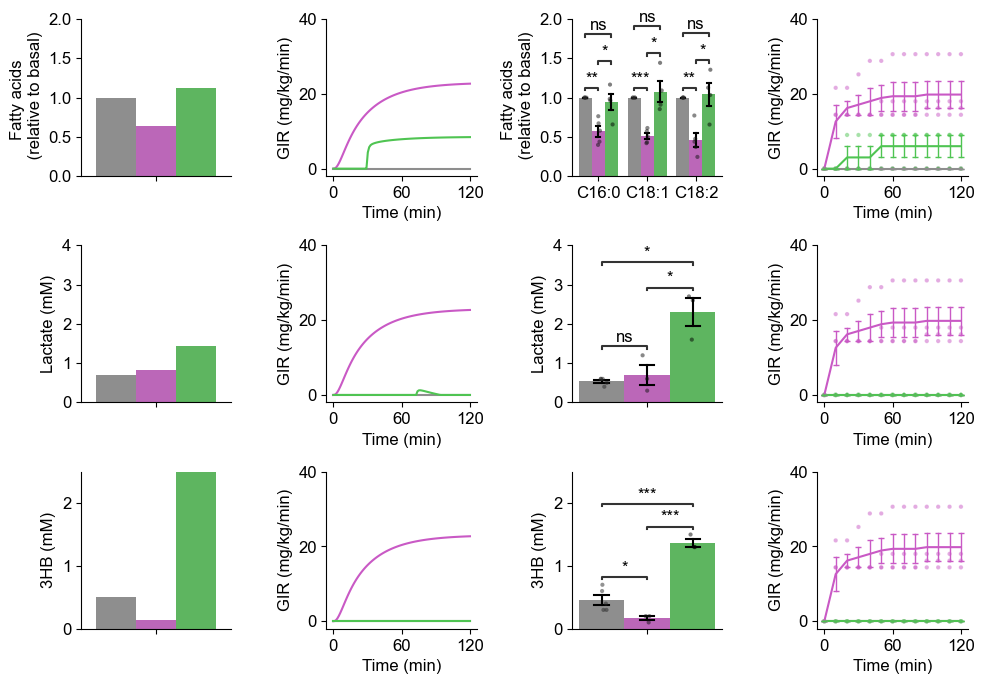

In [15]:
# Make a 3x4 grid to compare infusate concnetration and GIR
fig, axs = plt.subplots(3,4, figsize=(10,7),)

# Fliter x=for steady state time > 100
x = x[x['time'] > 100]

# Row 1: Intralipid (unchanged)
hue_order = ['saline','insulin_low',  'insulin_low_intralipid',]
sns.barplot(data=x,  y='F', hue ='condition', hue_order=hue_order, ax=axs[0,0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue ='condition', 
             hue_order=hue_order, ax=axs[0,1], err_style="bars", legend=False, palette=palette)

hue_order = ['Saline', '1.25 mU Insulin', '1.25 mU Insulin + Intralipid',]
sns.barplot(data=FFA_clamp_intralipid, x='Species', y='FFA', ax=axs[0,2], hue='variable' , 
            hue_order=hue_order, legend=False, palette=palette,
            err_kws={'color': 'black','linewidth': 1.5}, capsize=0.25,
            errorbar='se',)
sns.stripplot(data=FFA_clamp_intralipid, x='Species', y='FFA', ax=axs[0,2], hue='variable' ,
            hue_order=hue_order, legend=False, color='black', dodge=True, 
           alpha=0.5, zorder=10, size=3)
pairs = [
    (('C16:0','Saline'),( 'C16:0','1.25 mU Insulin')),
    (('C18:1','Saline'),( 'C18:1','1.25 mU Insulin')),
    (('C18:2','Saline'),( 'C18:2','1.25 mU Insulin')),
    (('C16:0','1.25 mU Insulin'),( 'C16:0','1.25 mU Insulin + Intralipid')),
    (('C18:1','1.25 mU Insulin'),( 'C18:1','1.25 mU Insulin + Intralipid')),
    (('C18:2','1.25 mU Insulin'),( 'C18:2','1.25 mU Insulin + Intralipid')),
    (('C16:0','Saline'),( 'C16:0','1.25 mU Insulin + Intralipid')),
    (('C18:1','Saline'),( 'C18:1','1.25 mU Insulin + Intralipid')),
    (('C18:2','Saline'),( 'C18:2','1.25 mU Insulin + Intralipid')),
]
annotator = Annotator(axs[0,2], pairs, data=FFA_clamp_intralipid,
                       x='Species', y='FFA',
                        hue='variable' ,  hue_order=hue_order,)
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()
sns.lineplot(data=GIR_clamp_intralipid, x='time', y='GIR', ax=axs[0,3], 
             hue='variable',
             hue_order=hue_order, legend=False, 
             err_style="bars", err_kws=errorbar_kwargs, errorbar='se', palette=palette)
sns.scatterplot(data=GIR_clamp_intralipid[GIR_clamp_intralipid.variable.isin(hue_order)], 
                x='time', y='GIR', ax=axs[0,3], hue='variable' ,
              hue_order=hue_order, legend=False, palette=palette, s=10, zorder=0,alpha=0.5)

# Row 2: Lactate (was Row 3)
hue_order = ['saline','insulin_low', 'insulin_low_lactate',]
sns.barplot(data=x,  y='L', hue ='condition', hue_order=hue_order, ax=axs[1,0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue ='condition', 
             hue_order=hue_order, ax=axs[1,1], err_style="bars", legend=False, palette=palette)
hue_order = ['Saline', '1.25 mU Insulin', '1.25 mU Insulin + Lactate']
sns.barplot(data=lactate_clamp_lactate,  y='lactate', ax=axs[1,2], hue='variable' , 
            hue_order=hue_order, legend=False, palette=palette,  
            err_kws={'color': 'black','linewidth': 1.5}, capsize=0.25, errorbar='se',)
sns.stripplot(data=lactate_clamp_lactate,  y='lactate', ax=axs[1,2], hue='variable' ,
            hue_order=hue_order, legend=False, color='black', dodge=True, 
           alpha=0.5, zorder=10, size=3)
pairs = [
    (('Lactate','Saline'),( 'Lactate','1.25 mU Insulin')),
    (('Lactate','1.25 mU Insulin'),( 'Lactate','1.25 mU Insulin + Lactate')),
    (('Lactate','Saline'),( 'Lactate','1.25 mU Insulin + Lactate')),
]
annotator = Annotator(axs[1,2], pairs, data=lactate_clamp_lactate, x='name', y='lactate',
                        hue='variable' ,  hue_order=hue_order,)
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()
sns.lineplot(data=GIR_clamp_lactate, x='time', y='GIR', ax=axs[1,3], hue='variable' , 
             hue_order=hue_order, legend=False, err_style="bars", 
             err_kws=errorbar_kwargs, errorbar='se', palette=palette)
sns.scatterplot(data=GIR_clamp_lactate[GIR_clamp_lactate.variable.isin(hue_order)], x='time', y='GIR', ax=axs[1,3], hue='variable' ,
              hue_order=hue_order, legend=False, palette=palette, s=10, zorder=0,alpha=0.5)

# Row 3: 3HB (was Row 2)
hue_order = ['saline','insulin_low', 'insulin_low_3HB',]
sns.barplot(data=x,  y='K', hue ='condition', hue_order=hue_order, ax=axs[2,0], legend=False, palette=palette, )
sns.lineplot(data=GIR, x='time', y='GIR', hue ='condition', 
             hue_order=hue_order, ax=axs[2,1], err_style="bars", legend=False, 
             palette=palette)
hue_order = ['Saline', '1.25 mU Insulin', '1.25 mU Insulin + 3HB',]
sns.barplot(data=_3HB_clamp_3HB, y='3HB', ax=axs[2,2], hue='variable' , hue_order=hue_order, 
            legend=False, palette=palette,  err_kws={'color': 'black','linewidth': 1.5}, capsize=0.25,
            errorbar='se',)
sns.stripplot(data=_3HB_clamp_3HB, y='3HB', ax=axs[2,2], hue='variable' ,
            hue_order=hue_order, legend=False, color='black', dodge=True, 
           alpha=0.5, zorder=10, size=3)
pairs = [
    (('3HB','Saline'),( '3HB','1.25 mU Insulin')),
    (('3HB','1.25 mU Insulin'),( '3HB','1.25 mU Insulin + 3HB')),
    (('3HB','Saline'),( '3HB','1.25 mU Insulin + 3HB')),
]
annotator = Annotator(axs[2,2], pairs, data=_3HB_clamp_3HB, x='name', y='3HB',
                        hue='variable' ,  hue_order=hue_order,)
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()
sns.lineplot(data=GIR_clamp_3HB, x='time', y='GIR', ax=axs[2,3], hue='variable' , 
             hue_order=hue_order, legend=False, err_style="bars", 
             err_kws=errorbar_kwargs, errorbar='se', palette=palette)
sns.scatterplot(data=GIR_clamp_3HB[GIR_clamp_3HB.variable.isin(hue_order)], x='time', y='GIR', ax=axs[2,3], hue='variable' ,
              hue_order=hue_order, legend=False, palette=palette, s=10, zorder=0,alpha=0.5)

# Axis ylims
for ax in axs[:,1]:
    ax.set_ylim(-2, 40)
for ax in axs[:,3]:
    ax.set_ylim(-2, 40)

# Axis lims 
axs[0,0].set_ylim(0, 2)
axs[0,2].set_ylim(0, 2)

axs[1,0].set_ylim(0, 4)
axs[1,2].set_ylim(0, 4)

axs[2,0].set_ylim(0, 2.5)
axs[2,2].set_ylim(0, 2.5)

# Axis labels

# Y axis labels
axs[0,0].set_ylabel('Fatty acids \n (relative to basal)')
axs[0,1].set_ylabel('GIR (mg/kg/min)')
axs[0,2].set_ylabel('Fatty acids \n (relative to basal)')
axs[0,3].set_ylabel('GIR (mg/kg/min)')

axs[1,0].set_ylabel('Lactate (mM)')
axs[1,1].set_ylabel('GIR (mg/kg/min)')
axs[1,2].set_ylabel('Lactate (mM)')
axs[1,3].set_ylabel('GIR (mg/kg/min)')

axs[2,0].set_ylabel('3HB (mM)')
axs[2,1].set_ylabel('GIR (mg/kg/min)')
axs[2,2].set_ylabel('3HB (mM)')
axs[2,3].set_ylabel('GIR (mg/kg/min)')

# X axis labels
for i in range(3):
    axs[i,0].set_xlabel('')
    axs[i,1].set_xlabel('Time (min)')
    axs[i,2].set_xlabel('')
    axs[i,3].set_xlabel('Time (min)')

    axs[i,1].set_xticks([0, 60, 120])
    axs[i,3].set_xticks([0, 60, 120])

sns.despine()

plt.tight_layout()
# Save the figure
plt.savefig('output/insulin_clamp_simulation.svg', bbox_inches='tight')


In [16]:
GIR_clamp_lactate.variable.unique()

array(['Saline', '2.5 mU Insulin', '2.5 mU Insulin + Lactate',
       '1.25 mU Insulin', '1.25 mU Insulin + Lactate'], dtype=object)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

C18:1_Saline vs. C18:1_2.5 mU Insulin: Welch's t-test independent samples, P_val:1.725e-02 t=4.796e+00
C18:2_Saline vs. C18:2_2.5 mU Insulin: Welch's t-test independent samples, P_val:3.367e-03 t=8.545e+00
C18:1_2.5 mU Insulin vs. C18:1_2.5 mU Insulin + Intralipid: Welch's t-test independent samples, P_val:3.872e-01 t=-9.146e-01
C18:2_2.5 mU Insulin vs. C18:2_2.5 mU Insulin + Intralipid: Welch's t-test independent samples, P_val:6.702e-02 t=-2.120e+00
C16:0_Saline vs. C16:0_2.5 mU Insulin: Welch's t-test independent samples, P_val:3.932e-03 t=8.100e+00
C16:0_2.5 mU Insulin vs. C16:0_2.5 mU Insulin + Intralipid: Welch's t-test independent samples, P_val:2.902e-01 t=-1.134e+00
C18:1_Saline vs. C18:1_2.5 mU Insulin + Intralipid: Welch's t-test independent samples, P_val:5.835e-02 t=2.444e+00
C18:2_Sa

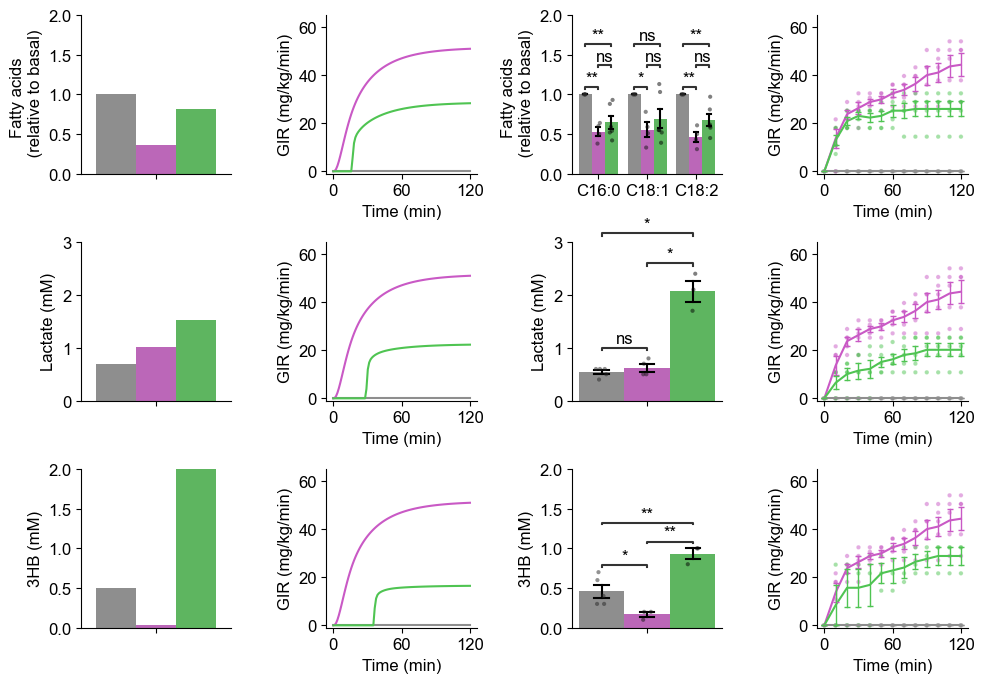

In [17]:
# Make a 3x4 grid to compare infusate concentration and GIR for high insulin (2.5mU)

fig, axs = plt.subplots(3, 4, figsize=(10, 7))


# Filter x for steady state time > 100
x_high = x[x['time'] > 100]

# Row 1: Intralipid
# Plot simulation
hue_order = ['saline', 'insulin_high', 'insulin_high_intralipid']

sns.barplot(data=x_high, y='F', hue='condition', hue_order=hue_order, ax=axs[0, 0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue='condition', hue_order=hue_order, ax=axs[0, 1], legend=False, palette=palette)

# Plot data
# Plot infusate concentration
hue_order = ['Saline', '2.5 mU Insulin', '2.5 mU Insulin + Intralipid']
sns.barplot(data=FFA_clamp_intralipid, x='Species', y='FFA', ax=axs[0, 2], 
            hue='variable', hue_order=hue_order, legend=False, palette=palette,
            err_kws={'color': 'black','linewidth': 1.5}, capsize=0.25, errorbar='se')
sns.stripplot(data=FFA_clamp_intralipid, x='Species', y='FFA', ax=axs[0, 2], hue='variable' ,
            hue_order=hue_order, legend=False, color='black', dodge=True, 
           alpha=0.5, zorder=10, size=3)


pairs = [
    (('C16:0','Saline'),( 'C16:0','2.5 mU Insulin')),
    (('C18:1','Saline'),( 'C18:1','2.5 mU Insulin')),
    (('C18:2','Saline'),( 'C18:2','2.5 mU Insulin')),
    (('C16:0','2.5 mU Insulin'),( 'C16:0','2.5 mU Insulin + Intralipid')),
    (('C18:1','2.5 mU Insulin'),( 'C18:1','2.5 mU Insulin + Intralipid')),
    (('C18:2','2.5 mU Insulin'),( 'C18:2','2.5 mU Insulin + Intralipid')),
    (('C16:0','Saline'),( 'C16:0','2.5 mU Insulin + Intralipid')),
    (('C18:1','Saline'),( 'C18:1','2.5 mU Insulin + Intralipid')),
    (('C18:2','Saline'),( 'C18:2','2.5 mU Insulin + Intralipid')),
]

annotator = Annotator(axs[0,2], pairs, data=FFA_clamp_intralipid,
                       x='Species', y='FFA',
                        hue='variable' ,  hue_order=hue_order,)

annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

# Plot GIR
sns.lineplot(data=GIR_clamp_intralipid, x='time', y='GIR', ax=axs[0, 3], hue='variable', hue_order=hue_order, legend=False, err_style="bars", err_kws=errorbar_kwargs, markers='o', errorbar='se', palette=palette)
sns.scatterplot(data=GIR_clamp_intralipid[GIR_clamp_intralipid.variable.isin(hue_order)], 
                x='time', y='GIR', ax=axs[0, 3], hue='variable' ,
              hue_order=hue_order, legend=False, palette=palette, s=10, zorder=0,alpha=0.5)

# Row 2: Lactate
# Plot simulation
hue_order = ['saline', 'insulin_high', 'insulin_high_lactate']

sns.barplot(data=x_high, y='L', hue='condition', hue_order=hue_order, ax=axs[1, 0], legend=False, palette=palette)
sns.lineplot(data=GIR, x='time', y='GIR', hue='condition', hue_order=hue_order, ax=axs[1, 1], legend=False, palette=palette)

# Plot data
# Plot infusate concentration
hue_order = ['Saline', '2.5 mU Insulin', '2.5 mU Insulin + Lactate']
sns.barplot(data=lactate_clamp_lactate, y='lactate', ax=axs[1, 2], hue='variable', hue_order=hue_order, legend=False, palette=palette,
            err_kws={'color': 'black','linewidth': 1.5}, capsize=0.25, errorbar='se')
sns.stripplot(data=lactate_clamp_lactate, y='lactate', ax=axs[1, 2], hue='variable' ,
            hue_order=hue_order, legend=False, color='black', dodge=True, 
           alpha=0.5, zorder=10, size=3)

pairs = [
    (('Lactate','Saline'),( 'Lactate','2.5 mU Insulin')),
    (('Lactate','2.5 mU Insulin'),( 'Lactate','2.5 mU Insulin + Lactate')),
    (('Lactate','Saline'),( 'Lactate','2.5 mU Insulin + Lactate')),
]

annotator = Annotator(axs[1,2], pairs, data=lactate_clamp_lactate, x='name', y='lactate',
                        hue='variable' ,  hue_order=hue_order,)

annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

# Plot GIR
sns.lineplot(data=GIR_clamp_lactate, x='time', y='GIR', ax=axs[1, 3], hue='variable', hue_order=hue_order, legend=False, err_style="bars", err_kws=errorbar_kwargs, markers='o', errorbar='se', palette=palette)
sns.scatterplot(data=GIR_clamp_lactate[GIR_clamp_lactate.variable.isin(hue_order)], x='time', y='GIR', ax=axs[1, 3], hue='variable' ,
              hue_order=hue_order, legend=False, palette=palette, s=10, zorder=0,alpha=0.5)

# Row 3: 3HB
# Plot simulation
hue_order = ['saline', 'insulin_high', 'insulin_high_3HB']

sns.barplot(data=x_high, y='K', hue='condition', hue_order=hue_order, ax=axs[2, 0], 
            legend=False, palette=palette)

sns.lineplot(data=GIR, x='time', y='GIR', hue='condition', 
            hue_order=hue_order, ax=axs[2, 1], 
            legend=False, palette=palette)

# Plot data
# Plot infusate concentration
hue_order = ['Saline', '2.5 mU Insulin', '2.5 mU Insulin + 3HB']
sns.barplot(data=_3HB_clamp_3HB, y='3HB', ax=axs[2, 2], hue='variable', 
            hue_order=hue_order, legend=False, palette=palette, 
            err_kws={'color': 'black','linewidth': 1.5}, capsize=0.25, errorbar='se')
sns.stripplot(data=_3HB_clamp_3HB, y='3HB', ax=axs[2, 2], hue='variable' ,
            hue_order=hue_order, legend=False, color='black', dodge=True, 
           alpha=0.5, zorder=10, size=3)


pairs = [
    (('3HB','Saline'),( '3HB','2.5 mU Insulin')),
    (('3HB','2.5 mU Insulin'),( '3HB','2.5 mU Insulin + 3HB')),
    (('3HB','Saline'),( '3HB','2.5 mU Insulin + 3HB')),
]

annotator = Annotator(axs[2,2], pairs, data=_3HB_clamp_3HB, x='name', y='3HB',
                        hue='variable' ,  hue_order=hue_order,)

annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()


# Plot GIR
sns.lineplot(data=GIR_clamp_3HB, x='time', y='GIR', ax=axs[2, 3], hue='variable', hue_order=hue_order, legend=False, err_style="bars", err_kws=errorbar_kwargs, markers='o', errorbar='se', palette=palette)
sns.scatterplot(data=GIR_clamp_3HB[GIR_clamp_3HB.variable.isin(hue_order)], x='time', y='GIR', ax=axs[2, 3], hue='variable' ,
              hue_order=hue_order, legend=False, palette=palette, s=10, zorder=0,alpha=0.5)

# Axis ylims
for ax in axs[:, 1]:
    ax.set_ylim(-1, 65)
for ax in axs[:, 3]:
    ax.set_ylim(-1, 65)

# Axis lims
axs[0, 0].set_ylim(0, 2)
axs[0, 2].set_ylim(0, 2)

axs[1, 0].set_ylim(0, 3)
axs[1, 2].set_ylim(0, 3)

axs[2, 0].set_ylim(0, 2)
axs[2, 2].set_ylim(0, 2)

# Axis labels
# Y axis labels
axs[0, 0].set_ylabel('Fatty acids \n (relative to basal)')
axs[0, 1].set_ylabel('GIR (mg/kg/min)')
axs[0, 2].set_ylabel('Fatty acids \n (relative to basal)')
axs[0, 3].set_ylabel('GIR (mg/kg/min)')

axs[1, 0].set_ylabel('Lactate (mM)')
axs[1, 1].set_ylabel('GIR (mg/kg/min)')
axs[1, 2].set_ylabel('Lactate (mM)')
axs[1, 3].set_ylabel('GIR (mg/kg/min)')

axs[2, 0].set_ylabel('3HB (mM)')
axs[2, 1].set_ylabel('GIR (mg/kg/min)')
axs[2, 2].set_ylabel('3HB (mM)')
axs[2, 3].set_ylabel('GIR (mg/kg/min)')

# X axis labels
for i in range(3):
    axs[i, 0].set_xlabel('')
    axs[i, 1].set_xlabel('Time (min)')
    axs[i, 2].set_xlabel('')
    axs[i, 3].set_xlabel('Time (min)')

    axs[i, 1].set_xticks([0, 60, 120])
    axs[i, 3].set_xticks([0, 60, 120])

sns.despine()
plt.tight_layout()

# Save the figure
plt.savefig('output/insulin_clamp_simulation_high_insulin.svg', bbox_inches='tight')
